In [1]:
import numpy as np
import scipy.optimize
import scipy
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def calc_mu(X):
    T = X.shape[0]
    N = X.shape[1]
    res = np.zeros(N)
    for t in range(T):
        res += X[t]
    return res / T

def calc_sigma(X):
    T = X.shape[0]
    N = X.shape[1]
    mu = calc_mu(X)
    res = np.zeros((N, N))
    for t in range(T):
        res += np.outer(X[t] - mu, (X[t] - mu).T)
    return res / T

def calc_alternative_answer(X):
    T = X.shape[0]
    return 2 / (T - 1) * np.sum(X[:-1], axis=0) - X[-1]

def f(x, base, Sigma):
    X = np.vstack((base, x))
    Sigma_ = calc_sigma(X)
    return np.linalg.norm(Sigma - Sigma_, ord=2)

def project_to_psd_cone(A):
  eigvals, eigvecs = np.linalg.eigh(A)
  eigvals[eigvals < 0] = 0
  A_psd = np.dot(eigvecs, np.dot(np.diag(eigvals), eigvecs.T))
  return A_psd

def get_two_answers(T, X_, SigmaT1):
    N = X_.shape[1]
    SigmaT1 = project_to_psd_cone(SigmaT1)
    SigmaT = calc_sigma(X_)
    muT = calc_mu(X_)
    A = (SigmaT1 - T/(T+1) * SigmaT) * (T+1)**2/T
    U, S, Vh = np.linalg.svd(A, full_matrices=False)
    return (-np.sqrt(S[0]) * U.T[0].reshape(N, 1) + muT.reshape(N, 1)).T, (np.sqrt(S[0]) * U.T[0].reshape(N, 1) + muT.reshape(N, 1)).T

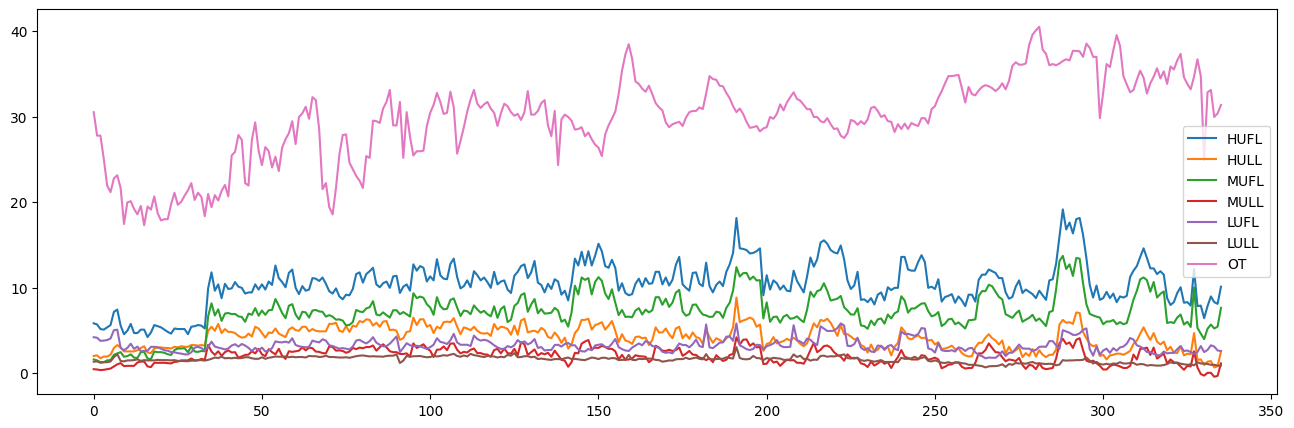

In [5]:
df = pd.read_csv('./ETTh1.csv')
df = df[['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']]

HUFL = df['HUFL']
HULL = df['HULL']
MUFL = df['MUFL']
MULL = df['MULL']
LUFL = df['LUFL']
LULL = df['LULL']
OT = df['OT']
TIME = 24 * 7 * 2
plt.figure(figsize=(16, 5))
plt.plot(HUFL[:TIME], label='HUFL')
plt.plot(HULL[:TIME], label='HULL')
plt.plot(MUFL[:TIME], label='MUFL')
plt.plot(MULL[:TIME], label='MULL')
plt.plot(LUFL[:TIME], label='LUFL')
plt.plot(LULL[:TIME], label='LULL')
plt.plot(OT[:TIME], label='OT')
plt.legend()
plt.show()

Names = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

X = np.array([HUFL, HULL, MUFL, MULL, LUFL, LULL, OT]).T
T = X.shape[0]
N = X.shape[1]

In [6]:
def make_experiment(T, variance):
    predicted = []
    real = []
    maxT = max(T)

    for i in range(maxT, 100):
        X_ = X[i-maxT:i]

        Sigma = [calc_sigma(X_[-Ti:]) for Ti in T]
        for i in range(len(Sigma)):
            Sigma[i] += np.random.normal(0, variance, Sigma[i].shape)
        y_hats = [get_two_answers(Ti, X_[-Ti:-1], Sigma[j]) for j, Ti in enumerate(T)]

        min_diameter = 1e9
        best_mask = None
        for mask in range(1 << len(T)):
            anses = [ y_hats[i][mask >> i & 1][0] for i in range(len(T)) ]
            diameter = 0
            for i in range(len(T)):
                for j in range(i+1, len(T)):
                    diameter = max(diameter, np.linalg.norm(anses[i] - anses[j]))
            if diameter < min_diameter:
                min_diameter = diameter
                best_mask = mask
        

        mean = np.zeros(N)
        for i in range(len(T)):
            mean += y_hats[i][best_mask >> i & 1][0] / len(T)
        predicted.append(mean)
        real.append(X_[-1])

    predicted = np.array(predicted)
    plt.figure(figsize=(12, 6))
    plt.plot(predicted, label='predicted', alpha=0.7)
    plt.plot(real, label='real', linestyle='dashed', alpha=0.7)
    Names_pred = [f'{name}_predicted' for name in Names]
    plt.legend(Names_pred + Names)
    plt.title('Predicted time series')
    plt.show()
    MAE = np.mean(np.abs(predicted - real))
    print('MAE:', MAE)
    MSE = np.mean((predicted - real)**2)
    print('MSE:', MSE)

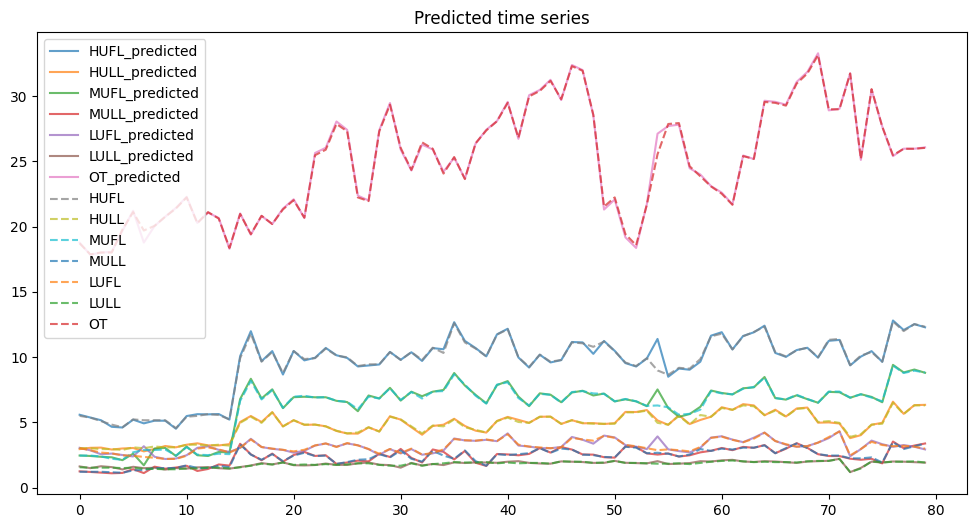

MAE: 0.07126451612660481
MSE: 0.0308692755128405


In [8]:
# Experiment with K = 2, T1 = 10, T2 = 20, N(0, 0.01) noise

T = [10, 20]
make_experiment(T, 0.01)

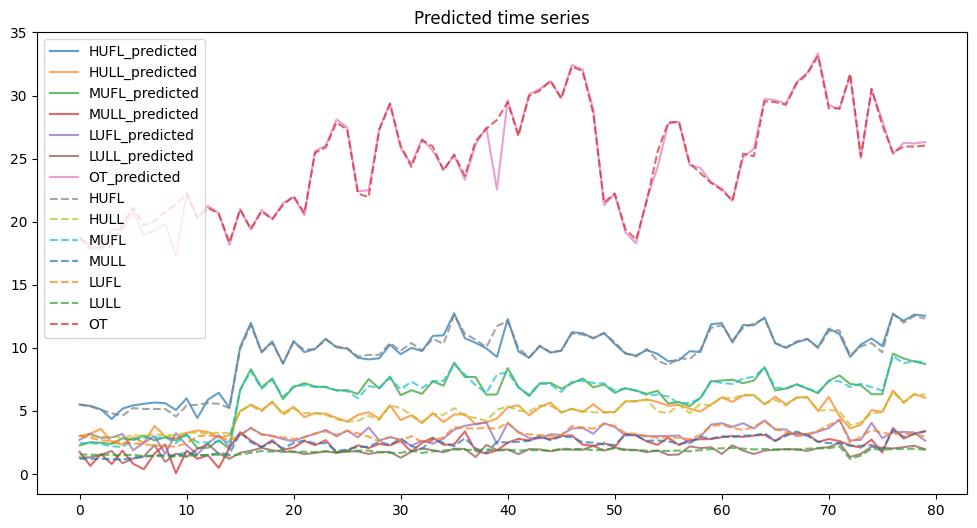

MAE: 0.24093258222045344
MSE: 0.1982185244889928


In [18]:
# Experiment with K = 2, T1 = 10, T2 = 20, N(0, 0.05) noise

T = [10, 20]
make_experiment(T, 0.05)

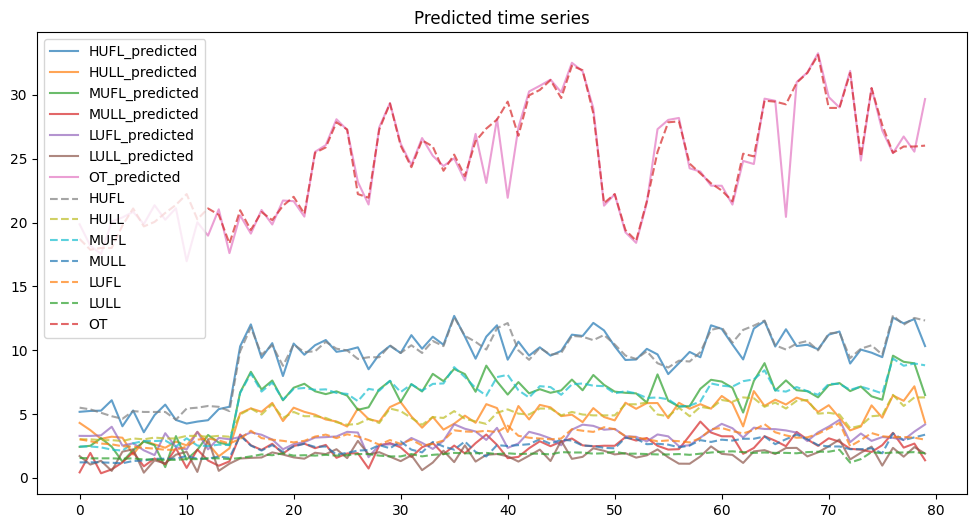

MAE: 0.46614738343472867
MSE: 0.7193008872621156


In [10]:
# Experiment with K = 2, T1 = 10, T2 = 20, N(0, 0.1) noise

T = [10, 20]
make_experiment(T, 0.1)

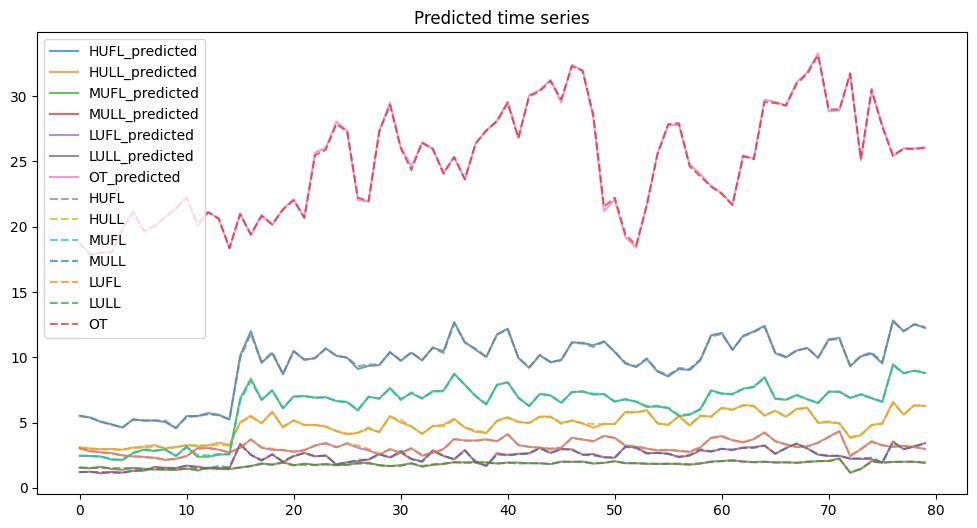

MAE: 0.04783053233222923
MSE: 0.004588830970605772


In [13]:
T = [5, 10, 15, 20]
make_experiment(T, 0.01)

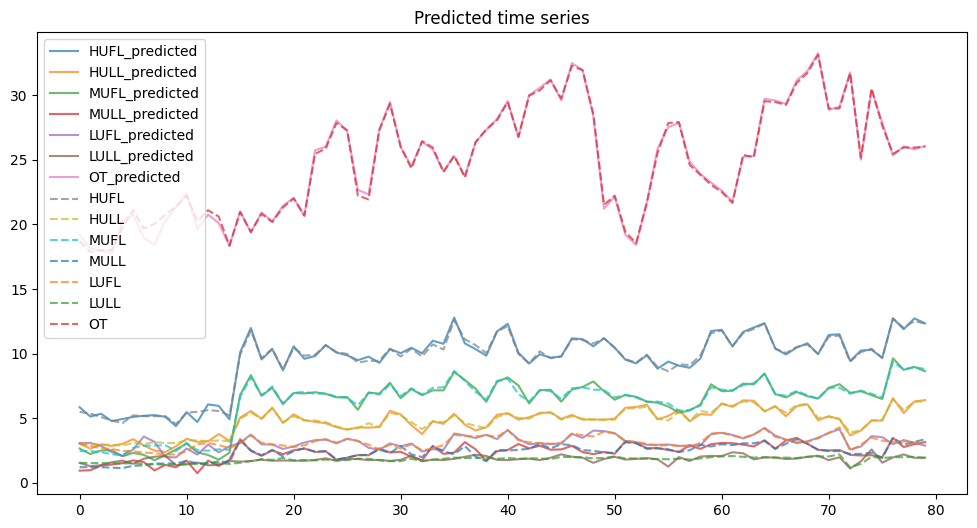

MAE: 0.15334203752201117
MSE: 0.05379627669199025


In [12]:
T = [5, 10, 15, 20]
make_experiment(T, 0.05)

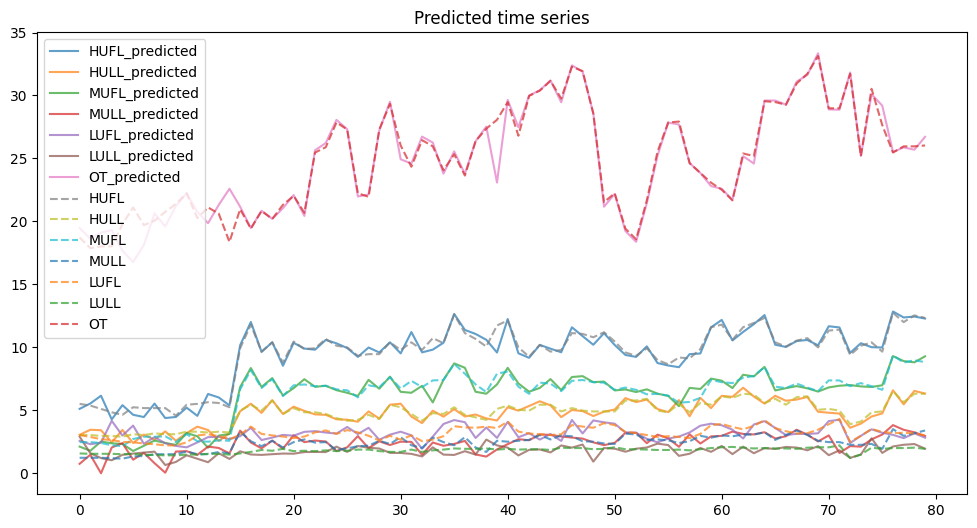

MAE: 0.30674312943135024
MSE: 0.28135501393477746


In [14]:
T = [5, 10, 15, 20]
make_experiment(T, 0.1)

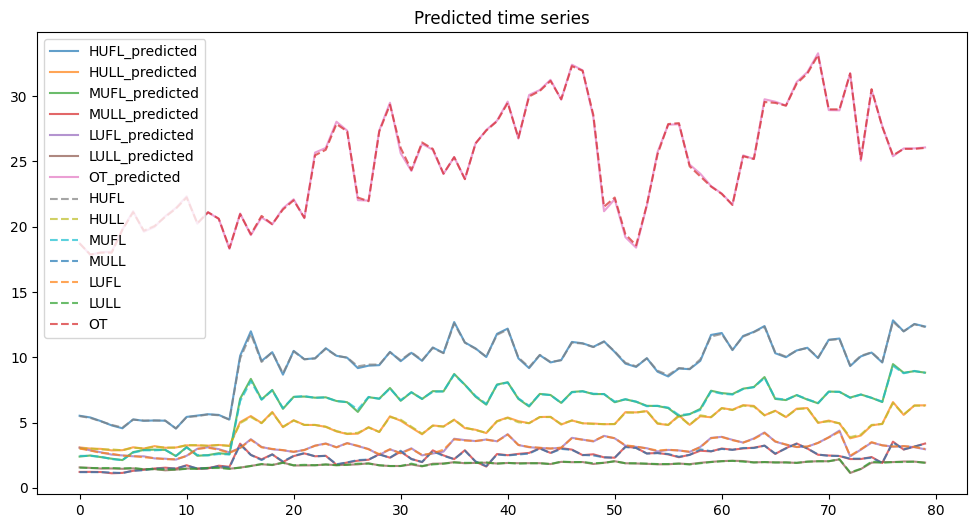

MAE: 0.038860325037283844
MSE: 0.0033597158923757667


In [15]:
T = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
make_experiment(T, 0.01)

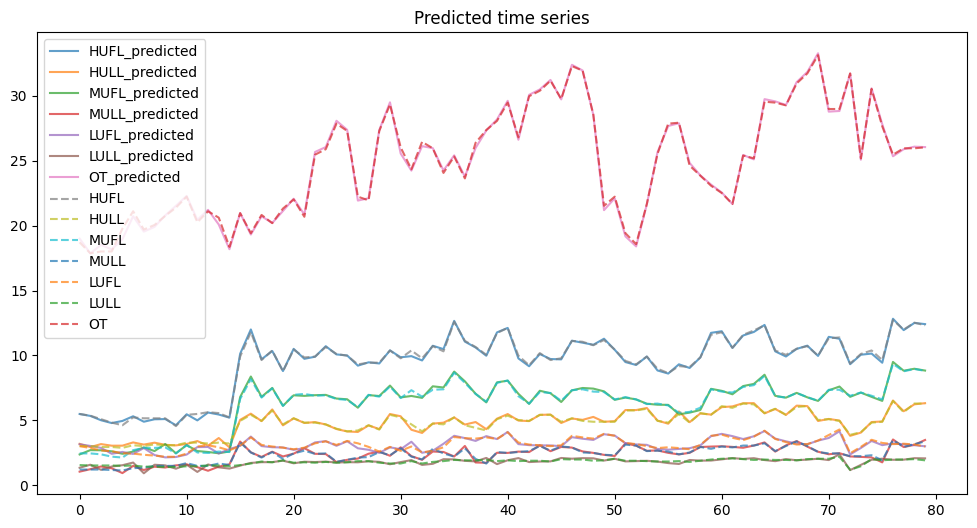

MAE: 0.096358553924964
MSE: 0.019355812057333745


In [16]:
T = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
make_experiment(T, 0.05)

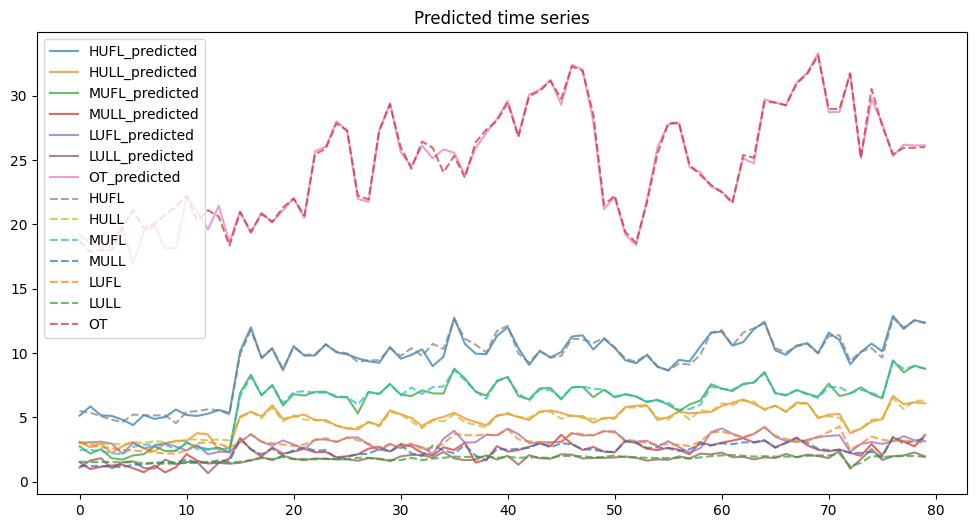

MAE: 0.2176619506869204
MSE: 0.148672231626199


In [17]:
T = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
make_experiment(T, 0.1)